## Regression-Based Classification

#### Table of Contents

* [Preliminaries](#Preliminaries)
* [Binomial Logistic Regression](#Binomial-Logistic-Regression)
    - [Logit Inference](#Logit-Inference)
        - [Logit Marginal Effects](#Logit-Marginal-Effects)
        - [Comparison to LPM](#Comparison-to-LPM)
        - [Logit Regularization](#Logit-Regularization)
    - [Logit Prediction Diagnostics](#Logit-Prediction-Diagnostics)
        - [Logit Null Model](#Logit-Null-Model)
        - [Logit Full Model](#Logit-Full-Model)
        - [Alternative Thresholds](#Alternative-Thresholds)
- [Multinomial Logistic Regression](#Multinomial-Logistic-Regression)
    - [MN Logit Inference](#MN-Logit-Inference)
        - [MN Logit Marginal Effects](#MN-Logit-Marginal-Effects)
        - [MN Logit Regularization](#MN-Logit-Regularization)
    - [MN Logit Prediction Diagnostics](#MN-Logit-Prediction-Diagnostics)
        - [MN Logit Null Model](#MN-Logit-Null-Model)
        - [MN Logit Full Model](#MN-Logit-Full-Model)

***
# Preliminaries
[TOP](#Regression-Based-Classification)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm # progress bar

import statsmodels.api as sm
from sklearn import linear_model as lm

from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'axes.titlesize': 24,
             'axes.labelsize': 20,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'figure.figsize': (8, 4.5)})
sns.set_style("white") # for plot_confusion_matrix()

In [2]:
df = pd.read_pickle('C:/Users/johnj/Documents/Data/aml in econ 02 spring 2021/class data/class_data.pkl')

In [3]:
df_prepped = df.drop(columns = ['urate_bin', 'year']).join([
    pd.get_dummies(df['urate_bin'], drop_first = True),
    pd.get_dummies(df.year, drop_first = True)    
])

In [4]:
y = df_prepped['pos_net_jobs'].astype(float)
x = df_prepped.drop(columns = 'pos_net_jobs')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 2/3, random_state = 490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

*******
# Binomial Logistic Regression
[TOP](#Regression-Based-Classification)

There are three primary ways to fit a logsitic regression:

- `statsmodels.api.Logit(y, x).fit()`
- `statsmodels.formula.api.logit(data = df, formula = 'y ~ x').fit()`
- `sklearn.linear_model.LogisticRegression().fit(x, y)`

************
## Logit Inference
[TOP](#Regression-Based-Classification)

By now, if you are thinking inference, then you should be thinking `statsmodels`.

In [5]:
fit_logit = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.599666
         Iterations 6


In [6]:
fit_logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:               Logit            Pseudo R-squared: 0.126     
Dependent Variable:  pos_net_jobs     AIC:              40700.1748
Date:                2021-03-02 14:19 BIC:              40936.2385
No. Observations:    33889            Log-Likelihood:   -20322.   
Df Model:            27               LL-Null:          -23242.   
Df Residuals:        33861            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -1.9804   0.1454 -13.6244 0.0000 -2.2653 -1.6955
pct_d_rgdp         0.0159   0.0014  11.0808 0.0000  0.0131  0.0187
emp_estabs         0.0383   0.0029  13.2672 0.0000  0.0327  0.0440
estabs_entry_rate  0.1938   0.0054  35.7595 0.0000  0.1832  0.2045
estabs_exit_rate  -0.1625   0.0060 -27.1367 0.0000 -0.1743 -0.1508
pop                0.0000   0.0000   2.7815 0.0054  0.0000  0.0000
pop_pct_black     -0.0037   0.0009  -3.9538 0.0001 -0.0055 -0.0019
pop_pct_hisp       0.0065   0.0010   6.6630 0.0000  0.0046  0.0084
lfpr               0.0014   0.0014   1.0370 0.2997 -0.0012  0.0041
density            0.0000   0.0000   0.8976 0.3694 -0.0000  0.0000
lower              0.3427   0.0335  10.2204 0.0000  0.2770  0.4084
similar            0.1708   0.0357   4.7822 0.0000  0.1008  0.2408
2003               1.0795   0.0685  15.7513 0.0000  0.9451  1.2138
2004               1.2705   0.0701  18.1212 0.0000  1.1330  1.4079
2005               1.2782   0.0718  17.7988 0.0000  1.1374  1.4189
2006               1.7408   0.0752  23.1429 0.0000  1.5934  1.8882
2007               0.5726   0.0679   8.4340 0.0000  0.4396  0.7057
2008               0.9002   0.0689  13.0671 0.0000  0.7652  1.0353
2009              -0.5546   0.0813  -6.8221 0.0000 -0.7139 -0.3953
2010               0.1881   0.0712   2.6427 0.0082  0.0486  0.3275
2011               1.2499   0.0694  18.0167 0.0000  1.1139  1.3858
2012               1.5995   0.0719  22.2615 0.0000  1.4587  1.7404
2013               1.2136   0.0701  17.3026 0.0000  1.0762  1.3511
2014               1.5303   0.0716  21.3646 0.0000  1.3899  1.6707
2015               1.6389   0.0738  22.2195 0.0000  1.4944  1.7835
2016               1.2858   0.0714  18.0141 0.0000  1.1459  1.4257
2017               1.1100   0.0703  15.7814 0.0000  0.9721  1.2478
2018               1.4769   0.0726  20.3342 0.0000  1.3346  1.6193
==================================================================

"""

***********
### Logit Marginal Effects 
[TOP](#Regression-Based-Classification)

In [7]:
# There is no summary2() method for marginal effects
fit_logit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           pos_net_jobs
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp            0.0033      0.000     11.150      0.000       0.003       0.004
emp_estabs            0.0079      0.001     13.394      0.000       0.007       0.009
estabs_entry_rate     0.0401      0.001     38.375      0.000       0.038       0.042
estabs_exit_rate     -0.0336      0.001    -28.236      0.000      -0.036      -0.031
pop                3.029e-08   1.09e-08      2.782      0.005    8.95e-09    5.16e-08
pop_pct_black        -0.0008      0.000     -3.957      0.000      -0.001      -0.000
pop_pct_hisp          0.0013      0.000      6.678      0.000       0.001       0.002
lfpr                  0.0003      0.000      1.037      0.300      -0.000       0.001
density             1.59e-06   1.77e-06      0.898      0.369   -1.88e-06    5.06e-06
lower                 0.0709      0.007     10.278      0.000       0.057       0.084
similar               0.0353      0.007      4.788      0.000       0.021       0.050
2003                  0.2232      0.014     15.973      0.000       0.196       0.251
2004                  0.2627      0.014     18.459      0.000       0.235       0.291
2005                  0.2643      0.015     18.120      0.000       0.236       0.293
2006                  0.3600      0.015     23.839      0.000       0.330       0.390
2007                  0.1184      0.014      8.467      0.000       0.091       0.146
2008                  0.1862      0.014     13.189      0.000       0.159       0.214
2009                 -0.1147      0.017     -6.834      0.000      -0.148      -0.082
2010                  0.0389      0.015      2.644      0.008       0.010       0.068
2011                  0.2585      0.014     18.345      0.000       0.231       0.286
2012                  0.3308      0.014     22.889      0.000       0.302       0.359
2013                  0.2510      0.014     17.594      0.000       0.223       0.279
2014                  0.3165      0.014     21.919      0.000       0.288       0.345
2015                  0.3389      0.015     22.840      0.000       0.310       0.368
2016                  0.2659      0.014     18.345      0.000       0.238       0.294
2017                  0.2295      0.014     16.001      0.000       0.201       0.258
2018                  0.3054      0.015     20.812      0.000       0.277       0.334
=====================================================================================
"""

******
### Comparison to LPM 
[TOP](#Regression-Based-Classification)

For the sake of not exploding this notebook with summaries, let's use a simplier model:

In [8]:
sm.Logit(y_train, x_train[['const', 'pct_d_rgdp', 'estabs_exit_rate']]).fit().get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.670597
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           pos_net_jobs
Method:                          dydx
At:                           overall
====================================================================================
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
pct_d_rgdp           0.0057      0.000     17.597      0.000       0.005       0.006
estabs_exit_rate    -0.0280      0.001    -26.347      0.000      -0.030      -0.026
====================================================================================
"""

In [9]:
sm.OLS(y_train, x_train[['const', 'pct_d_rgdp', 'estabs_exit_rate']]).fit().params

const               0.791239
pct_d_rgdp          0.004881
estabs_exit_rate   -0.027172
dtype: float64

While these values are not identical, they are pretty close to one another. This is because OLS is always a first order approximation. Think/thank Taylor Series!

*********
### Logit Regularization 
[TOP](#Regression-Based-Classification)

We can also perform regularization, much like OLS:

In [10]:
%%time
param_grid = {
    'C': 10.0**np.arange(-5, -1, step = 1),
    'l1_ratio':  np.arange(0, 1, step = 0.1)
}

lr_cv = lm.LogisticRegression(penalty = 'elasticnet', solver = 'saga',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

Wall time: 15.3 s


{'C': 0.01, 'l1_ratio': 0.0}

# $C = \frac{1}{\alpha}$ 

In [11]:
# You will get convergence warnings
# They are due to difficulty converging
# We can address this by accepting some error
# with our qc_tol
# See below
fit_logit_reg = sm.Logit(y_train, x_train_std
                        ).fit_regularized(alpha = 1/best['C'],
                                          L1_wt = best['l1_ratio'],
                                          qc_tol = 1e3)
fit_logit_reg.params

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6148664747464858
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46


const                0.242299
pct_d_rgdp           0.129515
emp_estabs           0.160000
estabs_entry_rate    0.524969
estabs_exit_rate    -0.409562
pop                  0.044251
pop_pct_black       -0.043049
pop_pct_hisp         0.080563
lfpr                 0.011502
density              0.002602
lower                0.132604
similar              0.035284
2003                 0.102634
2004                 0.144029
2005                 0.138147
2006                 0.250307
2007                 0.000000
2008                 0.053639
2009                -0.260567
2010                -0.091555
2011                 0.132870
2012                 0.210276
2013                 0.123378
2014                 0.198359
2015                 0.217663
2016                 0.140723
2017                 0.099798
2018                 0.180612
dtype: float64

****************
## Logit Prediction Diagnostics
[TOP](#Regression-Based-Classification)

Here we are going to look at how to produce

- accuracy
- visualizing optimal threshold values
- the confusion matrix

In [12]:
fit_logit.predict(x_test).describe()

count    16945.000000
mean         0.562920
std          0.197952
min          0.000070
25%          0.440244
50%          0.595493
75%          0.712055
max          0.999784
dtype: float64

As you can see from the summary of `yhat`, `statsmodels` predicts the probabilities. **How do we know that to be true?**

***

To produce the **prediction** diagnostics, it is easier to use `sklearn`. 

********
### Logit Null Model
[TOP](#Regression-Based-Classification)

In classification, the **null model** is simply predicting the most frequently occuring class.

In [13]:
y_train.value_counts()

1.0    18992
0.0    14897
Name: pos_net_jobs, dtype: int64

In [14]:
acc_logit_null = np.mean(y_test == 1)
acc_logit_null

0.564886397167306

****
### Logit Full Model
[TOP](#Regression-Based-Classification)

For the sake of exposition, we are simply going to use all of the features.

In [15]:
fit_logit_sk = lm.LogisticRegression().fit(x_train, y_train)

In [16]:
yhat = fit_logit_sk.predict(x_test)

In [17]:
acc_logit = np.mean(yhat == y_test)
acc_logit

0.6076128651519622

In [18]:
(acc_logit - acc_logit_null)/acc_logit_null*100

7.563727538654397

Let's take a look at the confusion matrix.

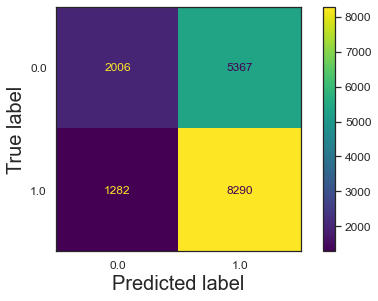

In [19]:
plot_confusion_matrix(fit_logit_sk, x_test, y_test)
plt.show()

We may have to consider changing thresholds.

***
### Alternative Thresholds
[TOP](#Regression-Based-Classification)

We can use `sklearn` to predict probabilities. 
It will produce a column for each class you have.
In this case, we have two classes. 

In [20]:
yhat_proba = fit_logit_sk.predict_proba(x_test)
yhat_proba[range(5), ]

array([[0.26809485, 0.73190515],
       [0.45851187, 0.54148813],
       [0.43310779, 0.56689221],
       [0.29880253, 0.70119747],
       [0.50159124, 0.49840876]])

In [21]:
min(yhat_proba[:, 1])

0.07673719653613793

The minimum probability of being in a county with positive net job creation is greater than the default threshold of 50%! Indeed! We will have to cross-validate the threshold.

There is no built in function to cross-validate the threshold for logit. 
We will have to manually set up the loops.

In [22]:
train = pd.merge(y_train, x_train, left_index = True, right_index = True)
kf = KFold(n_splits = 5, random_state = 490, shuffle = True)
alpha = np.round(    np.arange(0.5, 0.7, step = 0.01), 2    )

In [23]:
accuracy = {}

for a in tqdm(alpha):
    acc = []
    for trn, tst in kf.split(train):
        yhat = (lm.LogisticRegression(solver = 'liblinear'
                                      ).fit(train.iloc[trn, 1:], train.iloc[trn, 0]
                                           ).predict_proba(train.iloc[tst, 1:])[:, 1] > a)*1
        acc.append(np.mean(yhat == train.iloc[tst, 0]))
    accuracy[a] = np.mean(acc)
    
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


{0.5: 0.5742573567679164,
 0.51: 0.5788901093221728,
 0.52: 0.5847327976053558,
 0.53: 0.5912540955594471,
 0.54: 0.5949130268212747,
 0.55: 0.5897785555808525,
 0.56: 0.5738736582907847,
 0.57: 0.5469327524715297,
 0.58: 0.5242114979967347,
 0.59: 0.5037035382507433,
 0.6: 0.4908084044704868,
 0.61: 0.48180843830126313,
 0.62: 0.47428392938415403,
 0.63: 0.4685298629313658,
 0.64: 0.46404455944295997,
 0.65: 0.46065109745601707,
 0.66: 0.45699206605160836,
 0.67: 0.4541592327127672,
 0.68: 0.45247725097990604,
 0.69: 0.4505002230784848}

In [24]:
print('max accuracy at alpha = %s' % max(accuracy, key = accuracy.get))

max accuracy at alpha = 0.54


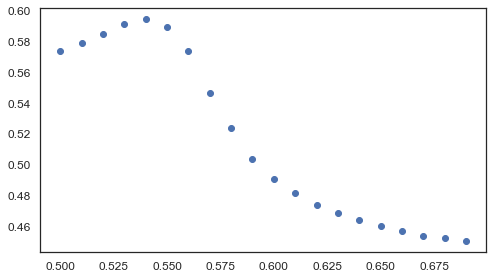

In [25]:
plt.scatter(accuracy.keys(), accuracy.values())
plt.show()

The maximum is $\alpha=0.54$. However, from the figure, it looks like we can choose either 0.54 or 0.55. Since the accuracy drops off quickly to the right, we may be safer using 0.54.

Because we have adjusted the threshold, we need to manually calculate the confusion matrix.

In [26]:
best_alpha = max(accuracy, key = accuracy.get)
yhat_class = (yhat_proba[:, 1] >= best_alpha)*1

TN = sum(((y_test == yhat_class) & (y_test == 0))*1)
FP = sum(((y_test != yhat_class) & (y_test == 0))*1)
FN = sum(((y_test != yhat_class) & (y_test == 1))*1)
TP = sum(((y_test == yhat_class) & (y_test == 1))*1)

print(np.array([[TN, FP],[FN, TP]]))
print((TN + TP)/(TN + FN + FP + TP))
acc_logit_54 = np.mean(yhat_class == y_test)
print(acc_logit_54, '\n')

[[3630 3743]
 [2858 6714]]
0.6104455591619947
0.6104455591619947 



Finally, we can compute the percent improvement from the null model.

In [27]:
round(  (acc_logit_54 - acc_logit_null)/acc_logit_null*100, 2)

8.07

It looks we have improved our prediction by just over 8%.

************
# Multinomial Logistic Regression 
[TOP](#Regression-Based-Classification)

We need to adjust features and labels to retreive our multiclass label. It is easier to start from scratch. 

Because logisitc functions struggle with many dummy variables, we are going to simply drop the fixed effects.

We will be converting the categorical label to a `category` type of object prior to splitting. This is to ensure consistent labels in the training and testing data.

In [28]:
df_prepped = df.drop(columns = 'year')
df_prepped['urate_bin'] = df_prepped['urate_bin'].astype('category')
df_prepped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50834 entries, (1001, 2002, 'Autauga, AL') to (56045, 2018, 'Weston, WY')
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   pct_d_rgdp         50834 non-null  float64 
 1   urate_bin          50834 non-null  category
 2   pos_net_jobs       50834 non-null  int32   
 3   emp_estabs         50834 non-null  float64 
 4   estabs_entry_rate  50834 non-null  float64 
 5   estabs_exit_rate   50834 non-null  float64 
 6   pop                50834 non-null  float64 
 7   pop_pct_black      50834 non-null  float64 
 8   pop_pct_hisp       50834 non-null  float64 
 9   lfpr               50834 non-null  float64 
 10  density            50834 non-null  float64 
dtypes: category(1), float64(9), int32(1)
memory usage: 6.2+ MB


In [29]:
df_prepped['urate_bin'].head()

fips  year  GeoName    
1001  2002  Autauga, AL     lower
      2003  Autauga, AL     lower
      2004  Autauga, AL     lower
      2005  Autauga, AL    higher
      2006  Autauga, AL    higher
Name: urate_bin, dtype: category
Categories (3, object): ['higher', 'lower', 'similar']

In [30]:
df_prepped['urate_bin'].cat.codes.head()

fips  year  GeoName    
1001  2002  Autauga, AL    1
      2003  Autauga, AL    1
      2004  Autauga, AL    1
      2005  Autauga, AL    0
      2006  Autauga, AL    0
dtype: int8

In [31]:
y = df_prepped['urate_bin']
x = df_prepped.drop(columns = 'urate_bin')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 2/3, random_state = 490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

*****************
## MN Logit Inference
[TOP](#Regression-Based-Classification)

In [32]:
fit_mnlogit = sm.MNLogit(y_train, x_train).fit(maxiter = 150)

Optimization terminated successfully.
         Current function value: 0.904853
         Iterations 6


In [33]:
fit_mnlogit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
==================================================================
Model:               MNLogit          Pseudo R-squared: 0.130     
Dependent Variable:  urate_bin        AIC:              61373.1393
Date:                2021-03-02 14:28 BIC:              61558.6179
No. Observations:    33889            Log-Likelihood:   -30665.   
Df Model:            20               LL-Null:          -35259.   
Df Residuals:        33867            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
  urate_bin = 0    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const -8.2408   0.1638 -50.3167 0.0000 -8.5618 -7.9198
       pct_d_rgdp  0.0083   0.0015   5.4073 0.0000  0.0053  0.0114
     pos_net_jobs  0.1383   0.0292   4.7272 0.0000  0.0809  0.1956
       emp_estabs  0.0155   0.0033   4.7576 0.0000  0.0091  0.0219
estabs_entry_rate -0.0321   0.0053  -6.0469 0.0000 -0.0425 -0.0217
 estabs_exit_rate -0.0957   0.0064 -14.8573 0.0000 -0.1083 -0.0830
              pop  0.0000   0.0000   2.0269 0.0427  0.0000  0.0000
    pop_pct_black -0.0153   0.0013 -11.5958 0.0000 -0.0179 -0.0127
     pop_pct_hisp  0.0122   0.0011  11.5112 0.0000  0.0101  0.0143
             lfpr  0.1160   0.0018  64.9181 0.0000  0.1125  0.1195
          density  0.0000   0.0000   1.5776 0.1147 -0.0000  0.0000
------------------------------------------------------------------
  urate_bin = 1    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const -2.8091   0.1601 -17.5494 0.0000 -3.1228 -2.4953
       pct_d_rgdp  0.0024   0.0018   1.3195 0.1870 -0.0012  0.0060
     pos_net_jobs  0.0556   0.0325   1.7114 0.0870 -0.0081  0.1193
       emp_estabs  0.0345   0.0034  10.1377 0.0000  0.0278  0.0412
estabs_entry_rate -0.0403   0.0062  -6.5391 0.0000 -0.0523 -0.0282
 estabs_exit_rate -0.0638   0.0072  -8.8031 0.0000 -0.0780 -0.0496
              pop  0.0000   0.0000   3.8480 0.0001  0.0000  0.0000
    pop_pct_black -0.0095   0.0012  -8.1216 0.0000 -0.0117 -0.0072
     pop_pct_hisp  0.0017   0.0013   1.3866 0.1656 -0.0007  0.0042
             lfpr  0.0333   0.0018  18.5938 0.0000  0.0298  0.0368
          density  0.0000   0.0000   1.8199 0.0688 -0.0000  0.0000
==================================================================

"""

In [34]:
y_train.cat.categories

Index(['higher', 'lower', 'similar'], dtype='object')

We can see that the baseline class is 2, which is `similar`.

We can change the category levels if we wish:

In [35]:
fit_mnlogit = sm.MNLogit(y_train.cat.set_categories(new_categories = ['lower', 'similar', 'higher']),
                                                    x_train).fit(maxiter = 150)
fit_mnlogit.summary2()

Optimization terminated successfully.
         Current function value: 0.904853
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
==================================================================
Model:               MNLogit          Pseudo R-squared: 0.130     
Dependent Variable:  urate_bin        AIC:              61373.1393
Date:                2021-03-02 14:28 BIC:              61558.6179
No. Observations:    33889            Log-Likelihood:   -30665.   
Df Model:            20               LL-Null:          -35259.   
Df Residuals:        33867            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
  urate_bin = 0    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const  5.4318   0.1866  29.1109 0.0000  5.0661  5.7975
       pct_d_rgdp -0.0059   0.0019  -3.1928 0.0014 -0.0096 -0.0023
     pos_net_jobs -0.0826   0.0343  -2.4087 0.0160 -0.1499 -0.0154
       emp_estabs  0.0190   0.0035   5.3569 0.0000  0.0121  0.0260
estabs_entry_rate -0.0081   0.0065  -1.2467 0.2125 -0.0209  0.0047
 estabs_exit_rate  0.0319   0.0078   4.0665 0.0000  0.0165  0.0472
              pop  0.0000   0.0000   2.0204 0.0433  0.0000  0.0000
    pop_pct_black  0.0059   0.0015   3.8319 0.0001  0.0029  0.0089
     pop_pct_hisp -0.0105   0.0013  -8.1890 0.0000 -0.0130 -0.0080
             lfpr -0.0827   0.0020 -41.4428 0.0000 -0.0866 -0.0788
          density  0.0000   0.0000   0.2440 0.8072 -0.0000  0.0000
------------------------------------------------------------------
  urate_bin = 1    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const  8.2408   0.1638  50.3167 0.0000  7.9198  8.5618
       pct_d_rgdp -0.0083   0.0015  -5.4073 0.0000 -0.0114 -0.0053
     pos_net_jobs -0.1383   0.0292  -4.7272 0.0000 -0.1956 -0.0809
       emp_estabs -0.0155   0.0033  -4.7576 0.0000 -0.0219 -0.0091
estabs_entry_rate  0.0321   0.0053   6.0469 0.0000  0.0217  0.0425
 estabs_exit_rate  0.0957   0.0064  14.8573 0.0000  0.0830  0.1083
              pop -0.0000   0.0000  -2.0269 0.0427 -0.0000 -0.0000
    pop_pct_black  0.0153   0.0013  11.5958 0.0000  0.0127  0.0179
     pop_pct_hisp -0.0122   0.0011 -11.5112 0.0000 -0.0143 -0.0101
             lfpr -0.1160   0.0018 -64.9181 0.0000 -0.1195 -0.1125
          density -0.0000   0.0000  -1.5776 0.1147 -0.0000  0.0000
==================================================================

"""

***********
### MN Logit Marginal Effects
[TOP](#Regression-Based-Classification)

In [36]:
fit_mnlogit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:              urate_bin
Method:                          dydx
At:                           overall
=====================================================================================
  urate_bin=lower      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp            0.0014      0.000      5.321      0.000       0.001       0.002
pos_net_jobs          0.0218      0.005      4.410      0.000       0.012       0.032
emp_estabs            0.0006      0.001      1.178      0.239      -0.000       0.002
estabs_entry_rate    -0.0033      0.001     -3.646      0.000      -0.005      -0.002
estabs_exit_rate     -0.0135      0.001    -12.259      0.000      -0.016      -0.011
pop                6.069e-09   7.85e-09      0.773      0.439   -9.31e-09    2.15e-08
pop_pct_black        -0.0022      0.000     -9.417      0.000      -0.003      -0.002
pop_pct_hisp          0.0021      0.000     12.016      0.000       0.002       0.002
lfpr                  0.0192      0.000     82.527      0.000       0.019       0.020
density            1.589e-06   1.42e-06      1.121      0.262   -1.19e-06    4.37e-06
-------------------------------------------------------------------------------------
urate_bin=similar      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp           -0.0002      0.000     -0.729      0.466      -0.001       0.000
pos_net_jobs         -0.0007      0.004     -0.154      0.878      -0.009       0.008
emp_estabs            0.0041      0.000      9.082      0.000       0.003       0.005
estabs_entry_rate    -0.0039      0.001     -4.576      0.000      -0.006      -0.002
estabs_exit_rate     -0.0033      0.001     -3.272      0.001      -0.005      -0.001
pop                 2.25e-08    6.3e-09      3.573      0.000    1.02e-08    3.48e-08
pop_pct_black        -0.0004      0.000     -2.406      0.016      -0.001   -7.59e-05
pop_pct_hisp         -0.0005      0.000     -3.125      0.002      -0.001      -0.000
lfpr                 -0.0025      0.000    -12.044      0.000      -0.003      -0.002
density            1.491e-06   1.09e-06      1.362      0.173   -6.55e-07    3.64e-06
-------------------------------------------------------------------------------------
 urate_bin=higher      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp           -0.0012      0.000     -4.247      0.000      -0.002      -0.001
pos_net_jobs         -0.0211      0.005     -4.090      0.000      -0.031      -0.011
emp_estabs           -0.0047      0.001     -8.287      0.000      -0.006      -0.004
estabs_entry_rate     0.0072      0.001      7.606      0.000       0.005       0.009
estabs_exit_rate      0.0167      0.001     14.981      0.000       0.015       0.019
pop               -2.857e-08   9.12e-09     -3.132      0.002   -4.65e-08   -1.07e-08
pop_pct_black         0.0026      0.000     12.893      0.000       0.002       0.003
pop_pct_hisp         -0.0016      0.000     -8.332      0.000      -0.002      -0.001
lfpr                 -0.0166      0.000    -68.660      0.000      -0.017      -0.016
density           -3.079e-06   1.64e-06     -1.877      0.060   -6.29e-06    1.35e-07
=====================================================================================
"""

*************
### MN Logit Regularization 
[TOP](#Regression-Based-Classification)

In [37]:
%%time
param_grid = {
    'C': 10.0**np.arange(-5, -1, step = 1),
    'l1_ratio':  np.arange(0, 1, step = 0.1)
}

lr_cv = lm.LogisticRegression(penalty = 'elasticnet', solver = 'saga',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

Wall time: 18 s


{'C': 0.01, 'l1_ratio': 0.5}

# $C = \frac{1}{\alpha}$

In [38]:
# You will get convergence warnings
# They are due to difficulty converging
# We can address this by accepting some error
# with our qc_tol
# See below
fit_logit_reg = sm.MNLogit(y_train, x_train_std
                          ).fit_regularized(alpha = 1/best['C'],
                                            L1_wt = best['l1_ratio'],
                                            qc_tol = 1e3)
fit_logit_reg.params

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9170222634572774
            Iterations: 48
            Function evaluations: 48
            Gradient evaluations: 48


,0,1
const,-0.210202,-0.736071
pct_d_rgdp,0.053859,0.000000
pos_net_jobs,0.045208,0.000658
emp_estabs,0.050222,0.140933
estabs_entry_rate,-0.063547,-0.078584
estabs_exit_rate,-0.228397,-0.143882
pop,0.014490,0.045453
pop_pct_black,-0.184031,-0.109292
pop_pct_hisp,0.138715,0.000000
lfpr,1.256061,0.345394


From here, you can decide whether or not to keep variables if you wish to refit without regularization.
As a rule of thumb, drop features that are 50% zero across classes.

***
## MN Logit Prediction Diagnostics
[TOP](#Regression-Based-Classification)

We will proceed as we did for the binomial logistic regression.
We will first fit the null model and then compare it to another model.

********
### MN Logit Null Model
[TOP](#Regression-Based-Classification)

In [39]:
y_train.value_counts()

higher     14820
lower      12856
similar     6213
Name: urate_bin, dtype: int64

We can see that the largest grouping of counties have much higher than national unemployment rates.
We will predict that class.

In [40]:
acc_mnlogit_null = np.mean(y_test == 'higher')
acc_mnlogit_null

0.43416937149601653

*******
### MN Logit Full Model
[TOP](#Regression-Based-Classification)

In [41]:
fit_mnlogit_sk = lm.LogisticRegression(solver = 'liblinear').fit(x_train, y_train)

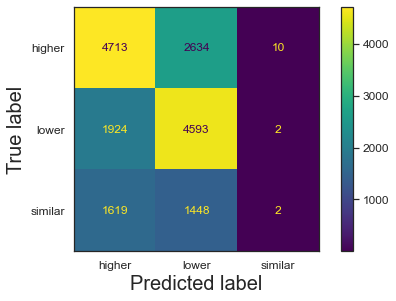

In [42]:
plot_confusion_matrix(fit_mnlogit_sk, x_test, y_test)
plt.show()

It looks like we are having trouble predicting the county unemployment rate similar to the national.

Let's take a look at the overall accuracy.

In [43]:
yhat = fit_mnlogit_sk.predict(x_test)
acc_mnlogit = np.mean(yhat == y_test)
acc_mnlogit

0.5493065801121275

Yikes.

In [44]:
round(100*(acc_mnlogit - acc_mnlogit_null)/acc_mnlogit_null, 2)

26.52

Not a bad improvement, but remember that we are only getting it correct barely more than 50% of the time.